**If you just want to see the cool results, look for starred (\*) headers.**

In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display

PATH = os.path.abspath('..')
sys.path.append(f'/home/john/projects/convnet-demo/src')
from multiclass import *

# Loading a pretrained network

In [6]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv, index_col=0)

display(df.sample(5, random_state=256))

,oh_p50
objID,
1237662302449500701,8.952116
1237665024905248887,8.724266
1237671939798073517,8.959539
1237662640658121002,8.992033
1237657611805196484,8.326750


In [7]:
# test-train split
n = len(df)
val_idxs = get_cv_idxs(n, val_pct=0.2, seed=256)

In [22]:
arch = resnet34
sz = 128
bs = 128

# get data transformers and ClassifierData object (for regression)
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_multiclass_csv(PATH, 'train', train_label_csv, tfms=tfms, bs=bs,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4)

n_batch = len(data.trn_y) // bs

# initialize pretrained network
learn = ConvLearner.pretrained(arch, data)
learn.crit = rmse

In [23]:
learn.load('resnet34-single_sz128-bs128')
learn.crit = rmse

In [24]:
# new batchsize
bs = 8

learn.data_.bs = bs

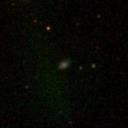

In [27]:
fn = PATH + '/' + data.val_ds.fnames[0]
img = PIL.Image.open(fn); 
img

As a reminder of how this is trained, below is an example of its performance on real test SDSS data:

![Example image](../../../galaxy-cnns/docs/figures/example.png)

# Model activations for an example training image

See [this notebook](https://github.com/kheyer/ML-DL-Projects/tree/master/Dog%20Breed%20CNN%20Visualizations)

In [30]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
model=learn.model
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [106]:
def return_sequential(layer_num, model):
    return nn.Sequential(*list(model.children())[:layer_num])

class get_activation_layer(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.layer_models = []
        for i in range(len(self.model)):
             self.layer_models.append(return_sequential(i, self.model))
    def forward(self, x):
        self.outputs = []
        for i in range(len(self.model)):
            self.outputs.append(self.layer_models[i](x))
        return self.outputs

/home/john/projects/lsstc-dsfp/hack/train/1237648704043942146.jpg


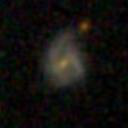

In [107]:
print(fn)
PIL.Image.open(fn)

In [108]:
img = val_tfms(open_image(fn))
                
tmp_model = get_activation_layer(model)
layer_outputs = tmp_model(V(img)[None])

In [111]:
# see which ones are conv layers and which are not
[i.dim() for i in layer_outputs]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [112]:
# keep 
layer_outputs = [i for i in layer_outputs if i.dim() == 4]

In [113]:
for i, layer in enumerate(layer_outputs):
    features = layer.data
    images = features.numpy()[0]
    print(images.shape)

(3, 128, 128)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 32, 32)
(64, 32, 32)
(128, 16, 16)
(256, 8, 8)
(512, 4, 4)
(1024, 1, 1)


I could, for instance, look at layer `5` (the 6th since they're 0-indexed) for every single galaxy

In [114]:
features = layer_outputs[5].data.numpy().squeeze()

In [115]:
features.max(axis=(1, 2))

array([5.12094, 0.96643, 2.31303, 3.37798, 2.80046, 3.99064, 3.36488, 1.39825, 1.48638, 2.79014, 1.74599,
       2.93143, 2.17406, 4.44756, 1.37861, 2.46583, 4.22012, 2.035  , 6.8064 , 2.75312, 2.3577 , 4.02475,
       4.09108, 3.39785, 2.60167, 3.81617, 3.00181, 4.26722, 2.30353, 2.10655, 2.91437, 1.09083, 5.02772,
       3.1944 , 1.49397, 2.65486, 3.4071 , 2.81921, 2.04142, 1.41753, 2.00326, 3.49244, 1.49142, 3.19459,
       4.04339, 3.78644, 3.22426, 4.40021, 2.46207, 1.99422, 2.5121 , 1.58448, 2.93695, 2.18578, 1.54027,
       4.26746, 3.53226, 1.06147, 2.29623, 0.98356, 2.90617, 0.98278, 4.24605, 2.20614], dtype=float32)

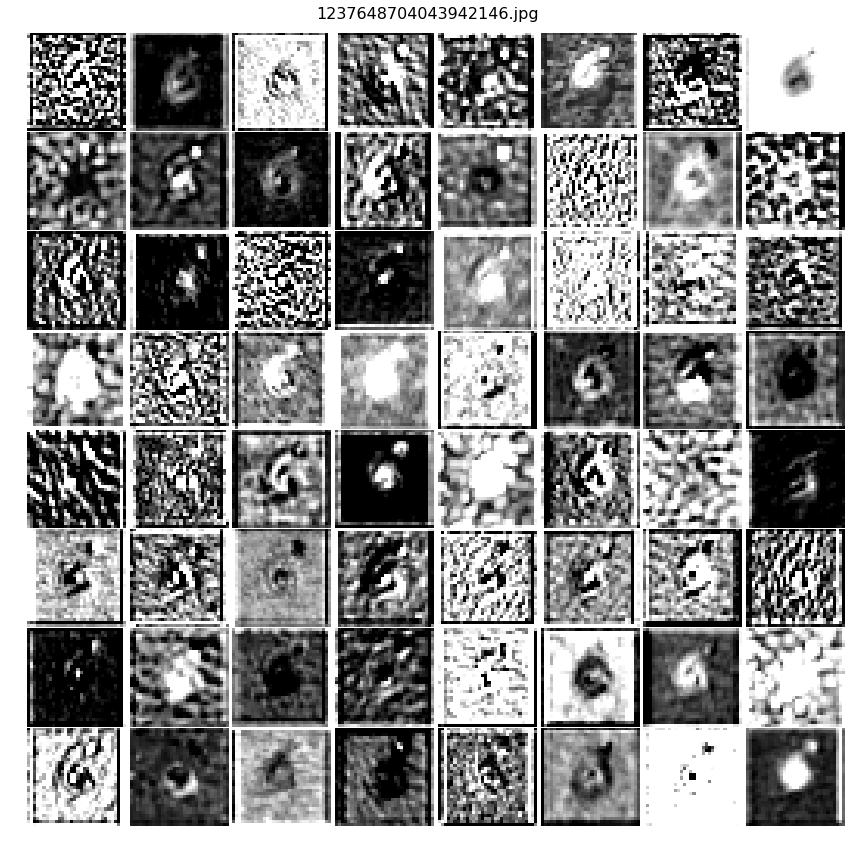

In [116]:
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(features[i], origin='upper', vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01, top=0.95)
fig.suptitle(f'{os.path.basename(fn)}', fontsize=16);

# Make method for analyzing activations in the sixth layer

In [298]:
@jit
def retrieve_layer(fn, layer=6, training=True):
    """Given a file name, get all of the sixth layer activations"""
    img = trn_tfms(open_image(fn)) if training else val_tfms(open_image(fn))
                
    tmp_model = get_activation_layer(model)
    layer_outputs = tmp_model(V(img)[None])
    
    return layer_outputs[layer - 1].data.numpy().squeeze()

Each one of these activations represents the same particular set of linear operations. Since in the image above, the sixth one (again index `5`) looks interesting, let's now grab that.

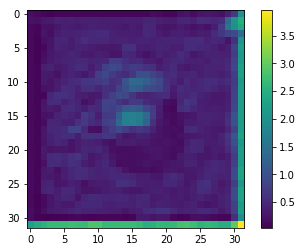

In [299]:
# first validation image
acts = retrieve_layer(fn, layer=6)
plt.imshow(acts[5])
plt.colorbar()

Repeat with a validation image

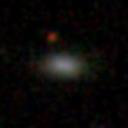

In [125]:
fn = PATH + '/' + data.val_ds.fnames[3]
PIL.Image.open(fn)

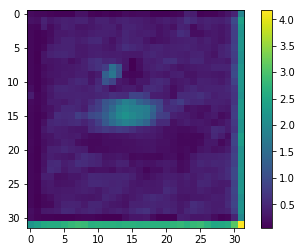

In [134]:
# first training image
acts = retrieve_layer_six(fn)
plt.imshow(acts[5])
plt.colorbar()

# Store a stack of layer-6 activations for all validation images

In [128]:
len(data.val_ds)

80

So this should be 80 x 64 x 32 x 32, or about 5 million elements. Should be okay!

In [129]:
all_layer6 = np.empty((80, 64, 32, 32), dtype=np.float32)

In [137]:
from numba import jit, njit

In [150]:
fns = np.array([f'{PATH}/{data.val_ds.fnames[i]}' for i in range(len(data.val_ds))])

@jit(parallel=True)
def load_all_layer6():
    """Loads in all of the layer-6 activations into a 4d tensor.
    
    TODO: make this more modular by allowing for arguments `ds`, and
    perhaps also allowing for an `out` array where data would be stored.
    """
    all_layer6 = np.empty((80, 64, 32, 32), dtype=np.float32)
    
    for i in range(len(data.val_ds)):
        all_layer6[i] = retrieve_layer_six(fns[i], training=False)
    
    return all_layer6

In [151]:
all_layer6 = load_all_layer6()

In [152]:
all_layer6.shape

(80, 64, 32, 32)

Let's look at a few of the 64 different channels

## Layer 6, channel 6

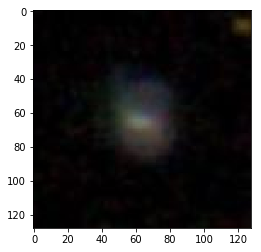

In [156]:
# random image
i = 32
img = open_image(fns[i])
plt.imshow(img)

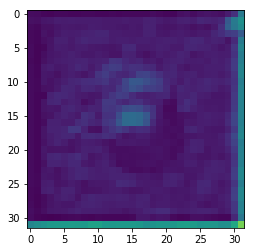

In [159]:
# channel 6 -> j=5
j = 5
plt.imshow(all_layer6[i, j, :], vmin=0, vmax=5)

In [187]:
def plot_lay6_image_pairs(idx, chan,):
    """Given inputs `idx` (which is the index number) and `chan`
    (the channel for that layer group), plots the original image
    and activations in that channel group.
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
    ax1.imshow(open_image(fns[idx]))
    ax2.imshow(all_layer6[idx, chan, :], vmin=0, vmax=np.max(all_layer6[:, chan, :]), cmap='gray')
    
    ax1.axis('off')
    ax2.axis('off')
    
    fig.suptitle(f'Validation Image {idx+1}, channel {chan+1}') # note these are *not* zero-indexed
    fig.subplots_adjust(wspace=0.02)
    plt.show()

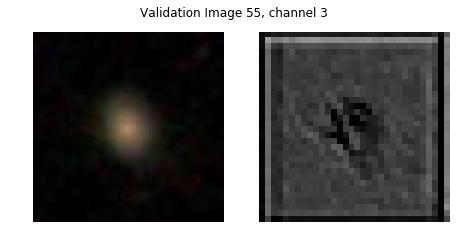

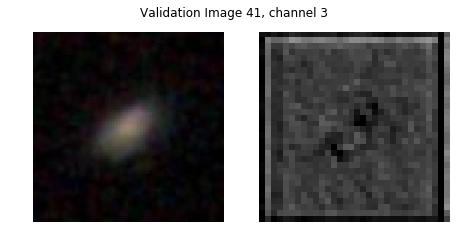

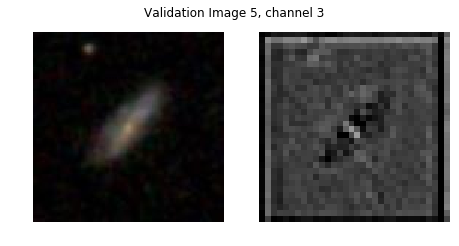

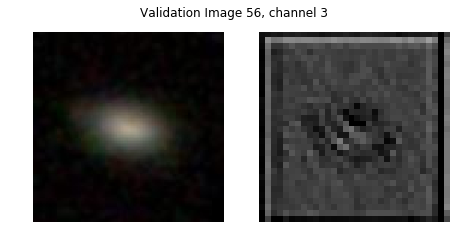

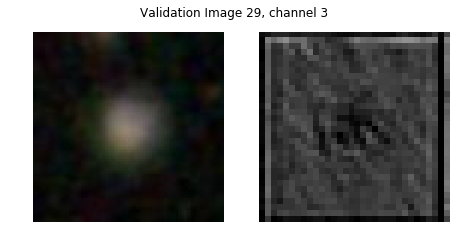

In [188]:
# channel 6
for i in np.random.choice(np.arange(80), size=5, replace=False):
    plot_lay6_image_pairs(i, chan)

## Layer 6, channel 2

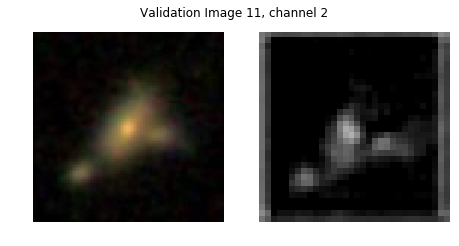

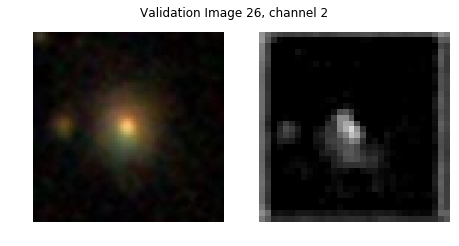

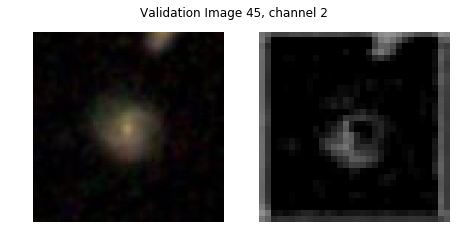

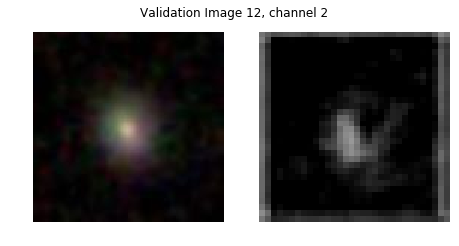

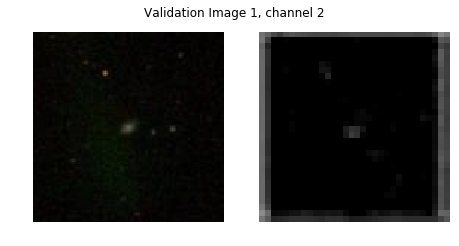

In [189]:
chan = 2
for i in np.random.choice(np.arange(80), size=5, replace=False):
    plot_lay6_image_pairs(i, chan - 1)

## (*) Inspect Validation image 42

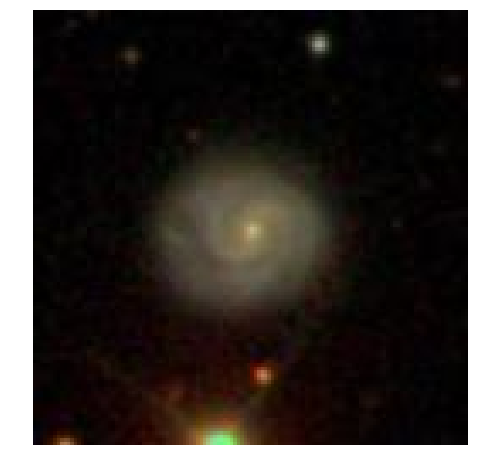

In [196]:
plt.figure(figsize=(8, 8))
plt.imshow(open_image(fns[42 - 1]))
plt.axis("off");

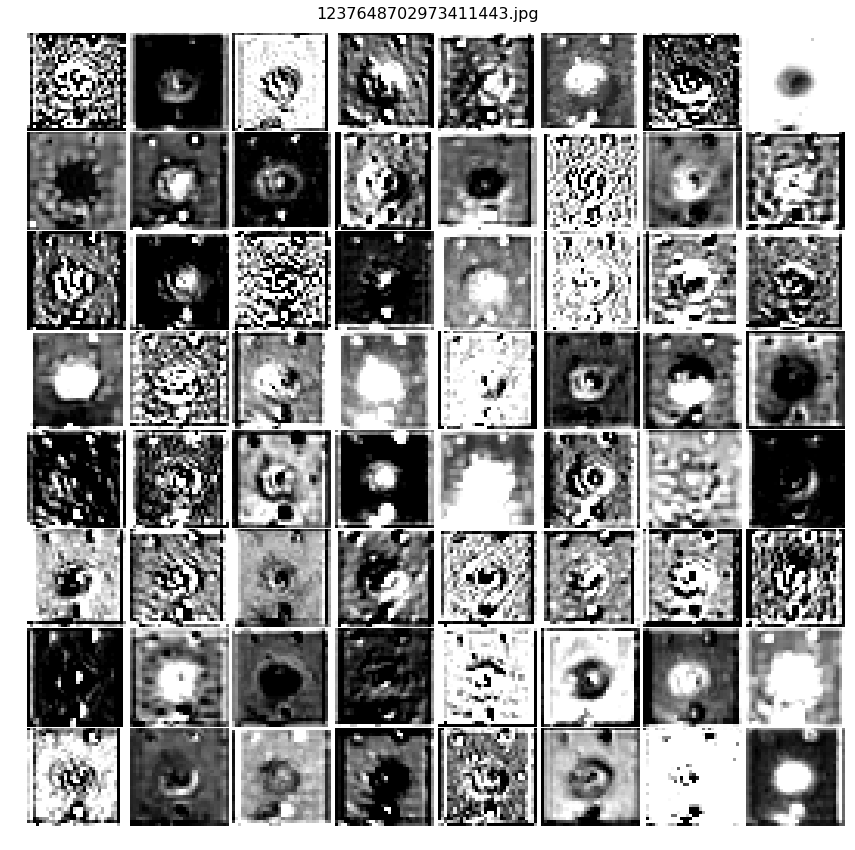

In [185]:
fig, axes = plt.subplots(8, 8, figsize=(12, 12))

image_num = 42

for i, ax in enumerate(axes.flat):
    ax.imshow(all_layer6[image_num - 1, i, :], origin='upper', vmin=0, vmax=1, cmap='gray')
    ax.axis('off')
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01, top=0.95)
fig.suptitle(f'{os.path.basename(fn)}', fontsize=16);

There's probably something that can be done using PCA here...

## Layer 6, channel 10

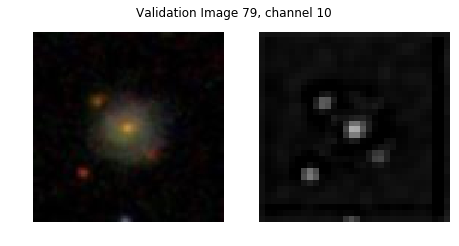

In [192]:
chan = 10
inum = 79

plot_lay6_image_pairs(inum - 1, chan - 1)

Here's something interesting -- does channel 10 not see the disk here?

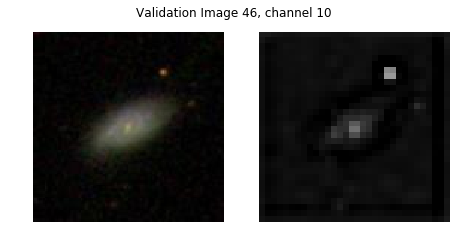

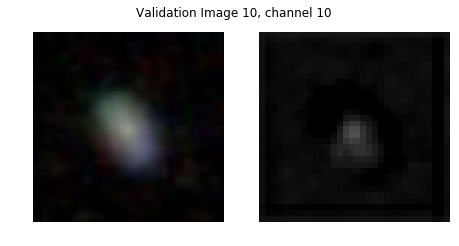

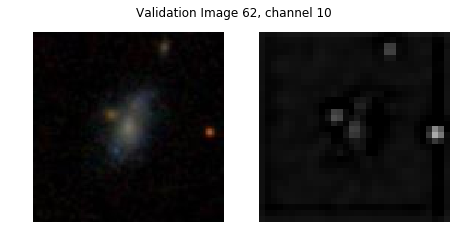

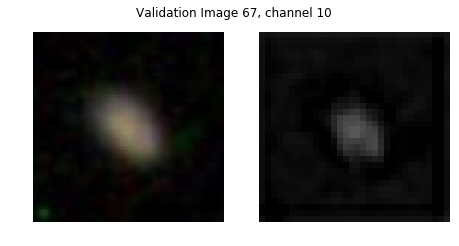

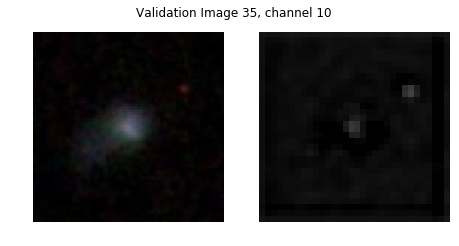

In [193]:
chan = 10
for i in np.random.choice(np.arange(80), size=5, replace=False):
    plot_lay6_image_pairs(i, chan - 1)

Hmm, it's not only a point source finder.

## Layer 6, channel 16

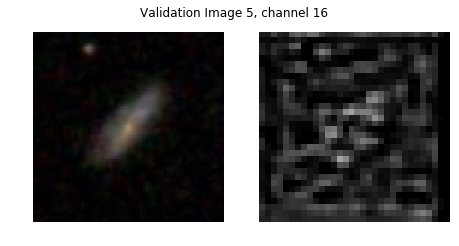

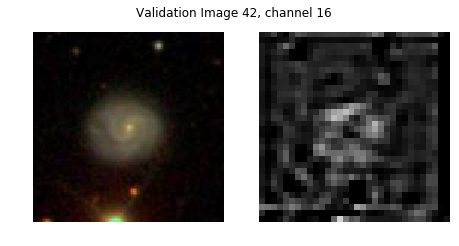

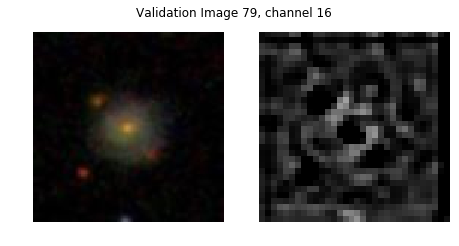

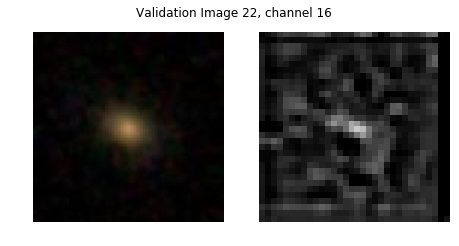

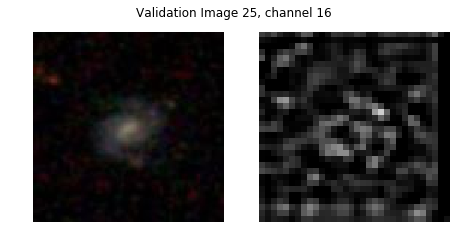

In [197]:
chan = 16
for i in np.random.choice(np.arange(80), size=5, replace=False):
    plot_lay6_image_pairs(i, chan - 1)

Some sort of multipole moment?

## Layer 6, channel 35

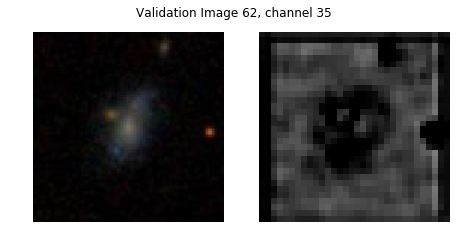

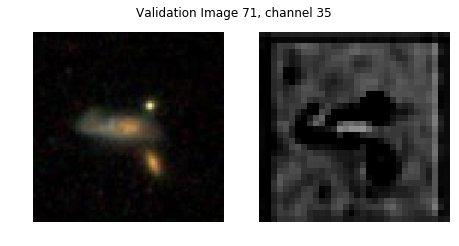

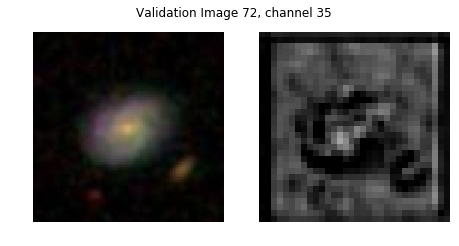

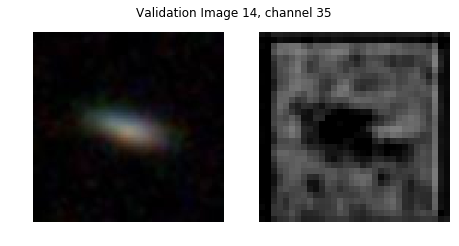

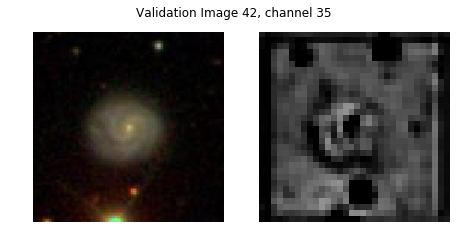

In [200]:
chan = 35
for i in np.random.choice(np.arange(80), size=5, replace=False):
    plot_lay6_image_pairs(i, chan - 1)

# t-SNE visualization of layer 6 activations

In [238]:
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import squareform

import seaborn as sns

## Reduce dimensionality of layer 6, channel 35

In [212]:
all_layer6.shape

(80, 64, 32, 32)

In [213]:
layer6_channel35 = all_layer6[:, 35 - 1].reshape(80, -1)

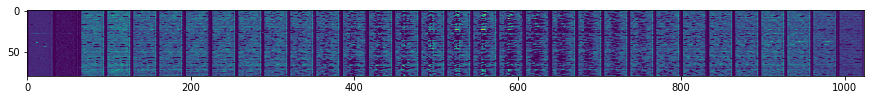

In [220]:
plt.figure(figsize=(15, 4))
plt.imshow(layer6_channel35,)

In [221]:
# do t-SNE transform
layer6_tsne = manifold.TSNE(n_components=2, perplexity=15).fit_transform(layer6_channel35)
tsne_df = pd.DataFrame(layer6_tsne, columns=['x','y'])

In [234]:
tsne_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
tsne_df.set_index('fname', drop=True, inplace=True)

In [235]:
tsne_df.head()

,x,y
fname,,
1237665441525596194,5.429017,4.453618
1237674289683300721,-20.400040,-56.708622
1237668336326672889,27.347275,5.251643
1237655370365861972,-26.839930,6.553844
1237662238015946871,-4.675434,64.154213


In [237]:
# get truth labels
tsne_df = tsne_df.join(df, on='fname')
tsne_df.sample(5)

,x,y,oh_p50
fname,,,
1237655370365861972,-26.839930,6.553844,8.605051
1237668297675374793,28.217409,70.470398,8.989969
1237665127475314874,34.274265,14.089975,9.012462
1237665549436322031,61.102276,2.555114,9.008768
1237664869750669442,-20.068012,49.131439,8.291190


Text(0.5,1,'Layer 6, channel 35 (t-SNE vs. metallicity)')

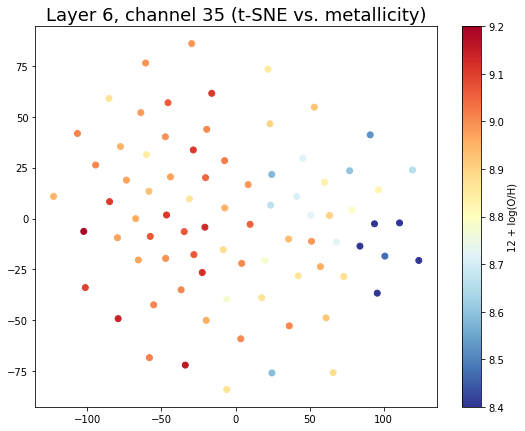

In [261]:
plt.figure(figsize=(9, 7))
sc = plt.scatter('x', 'y', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
plt.colorbar(sc, label='12 + log(O/H)')
plt.title('Layer 6, channel 35 (t-SNE vs. metallicity)', fontsize=18)

## (*) Use layer 6, channel 10

In [257]:
chan = 10

layer6_channel10 = all_layer6[:, chan - 1].reshape(80, -1)

In [258]:

layer6_tsne = manifold.TSNE(n_components=2, perplexity=30, init='pca', random_state=256).fit_transform(layer6_channel10)
tsne_df = pd.DataFrame(layer6_tsne, columns=['x','y'])

In [259]:
tsne_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
tsne_df = tsne_df.set_index('fname', drop=True).join(df, on='fname')

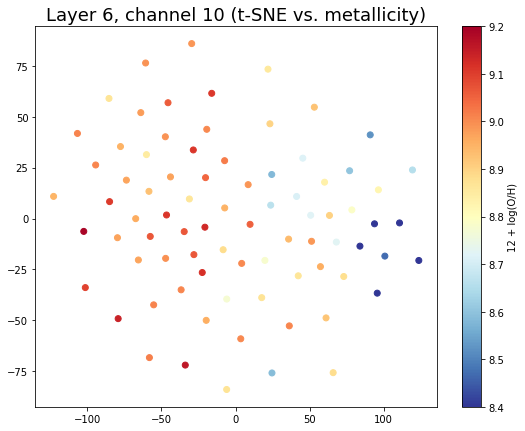

In [262]:
plt.figure(figsize=(9, 7))
sc = plt.scatter('x', 'y', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
plt.colorbar(sc, label='12 + log(O/H)')
plt.title(f'Layer 6, channel {chan} (t-SNE vs. metallicity)', fontsize=18);

## (*) Try all channels in layer 6

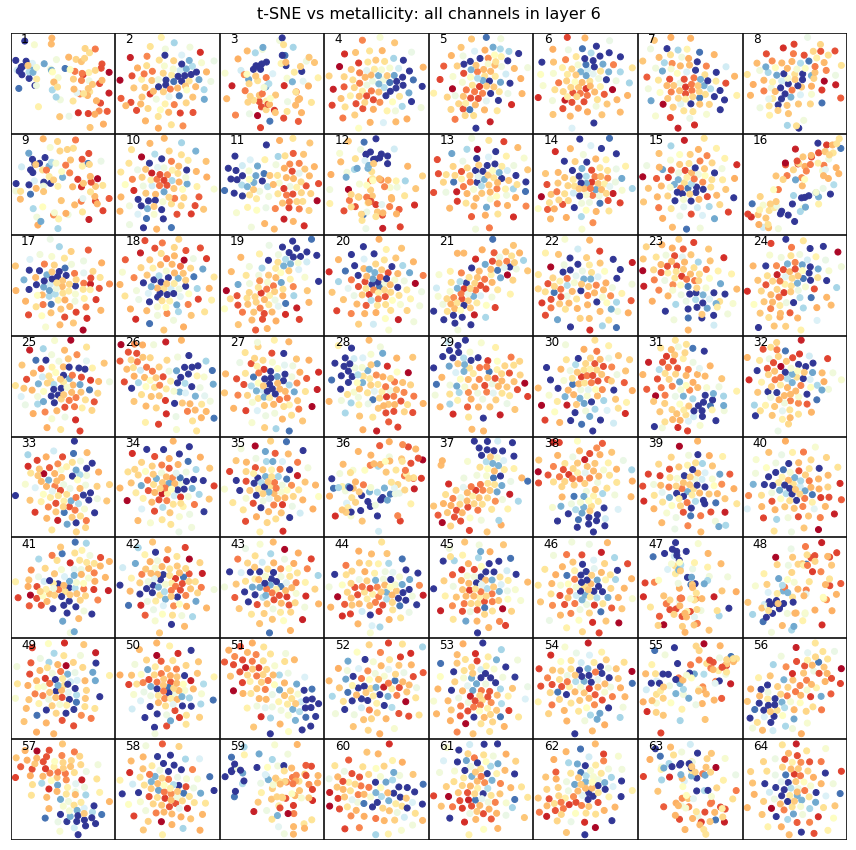

In [340]:
fig, axes = plt.subplots(8, 8, figsize=(12, 12))

for chan, ax in enumerate(axes.flat):
    flat_channel = all_layer6[:, chan - 1].reshape(80, -1)
    
    # t-SNE stuff
    tsne_chan = manifold.TSNE(n_components=2, perplexity=30, init='pca', random_state=256).fit_transform(flat_channel)
    tsne_df = pd.DataFrame(tsne_chan, columns=['x','y'])
    tsne_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
    tsne_df = tsne_df.set_index('fname', drop=True).join(df, on='fname')
    
    ax.scatter('x', 'y', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
    ax.text(0.1, 0.9, f'{chan + 1}', transform=ax.transAxes, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01, top=0.95)
fig.suptitle('t-SNE vs metallicity: all channels in layer 6', fontsize=16);



## Try all channels using t-SNE distances

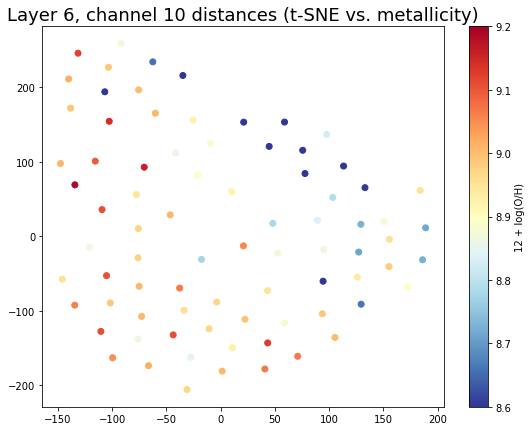

In [316]:
distances_chan10 = pairwise_distances(layer6_channel10)

layer10_dist_tsne = manifold.TSNE(n_components=2, perplexity=30).fit_transform(distances_chan10)
tsne_df = pd.DataFrame(layer10_dist_tsne, columns=['d1','d2'])

tsne_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
tsne_df = tsne_df.set_index('fname', drop=True).join(df, on='fname')

plt.figure(figsize=(9, 7))
sc = plt.scatter('d1', 'd2', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
plt.colorbar(sc, label='12 + log(O/H)')
plt.title(f'Layer 6, channel 10 distances (t-SNE vs. metallicity)', fontsize=18);

That's cool too, I guess

# Final conv layer activations


In [304]:
all_final = np.empty((80, 1024), dtype=np.float32)

for i in tqdm_notebook(range(len(data.val_ds))):
    all_final[i] = retrieve_layer(fns[i], layer=len(layer_outputs)).flatten()
    

In [318]:
all_final.shape

(80, 1024)

Note that the final convolution layer which results in size (80, 1024, 1, 1) is due to the adaptive MaxPool + adaptive AvgPool layers (which are concatenated)...

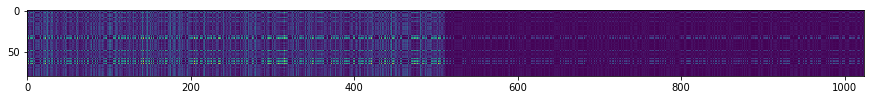

In [319]:
plt.figure(figsize=(15, 4))
plt.imshow(all_final,)

## Pairwise distances in final conv layer

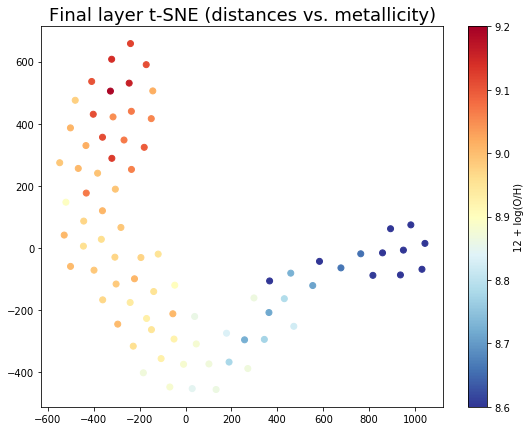

In [338]:
dists = pairwise_distances(all_final)

final_layer_tsne = manifold.TSNE(n_components=2, perplexity=30, init='pca', random_state=256).fit_transform(dists)
tsne_df = pd.DataFrame(final_layer_tsne, columns=['d1','d2'])

tsne_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
tsne_df = tsne_df.set_index('fname', drop=True).join(df, on='fname')

plt.figure(figsize=(9, 7))
sc = plt.scatter('d1', 'd2', data=tsne_df, c='oh_p50', vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
plt.colorbar(sc, label='12 + log(O/H)')
plt.title(f'Final layer t-SNE (distances vs. metallicity)', fontsize=18);

## Pure t-SNE 

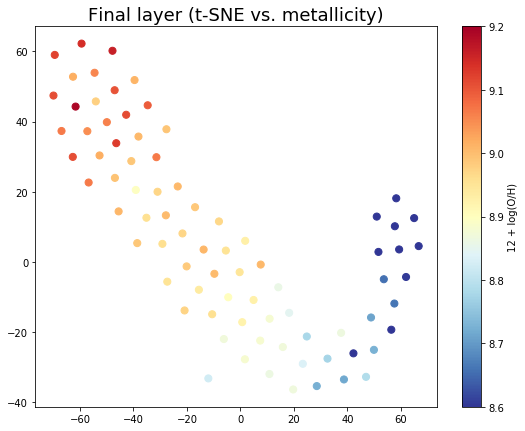

In [339]:

final_layer_tsne = manifold.TSNE(n_components=2, perplexity=30, init='pca', random_state=256).fit_transform(all_final)
tsne_df = pd.DataFrame(final_layer_tsne, columns=['d1','d2'])

tsne_df['fname'] = np.array([fn.strip('train/').strip('.jpg') for fn in learn.data.val_ds.fnames], dtype=np.int64)
tsne_df = tsne_df.set_index('fname', drop=True).join(df, on='fname')

plt.figure(figsize=(9, 7))
sc = plt.scatter('d1', 'd2', data=tsne_df, c='oh_p50', s=50, vmin=8.6, vmax=9.2, cmap='RdYlBu_r')
plt.colorbar(sc, label='12 + log(O/H)')
plt.title(f'Final layer (t-SNE vs. metallicity)', fontsize=18);